# NASA CMAPSS DATASET - Predicting Remaining Useful Lifetime Sample Project
Reference: https://towardsdatascience.com/predictive-maintenance-of-turbofan-engines-ec54a083127
## 1. Baseline model
EDA + Linear Regression
### 1.1. EDA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
dir_path = '/home/hdel-ai/Data/CMAPSSData/'

index_names = ['unit_nr', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i) for i in range(1,22)]
col_names = index_names + setting_names + sensor_names

In [3]:
train = pd.read_csv((dir_path + 'train_FD001.txt'), sep = '\s+', header=None, names = col_names)
test = pd.read_csv((dir_path + 'test_FD001.txt'), sep = '\s+', header=None, names = col_names)
y_test = pd.read_csv((dir_path + 'RUL_FD001.txt'), sep = '\s+', header=None, names = ['RUL'])

* train 데이터는 100 개의 엔진 데이터
* Total rows는 20631 개

In [4]:
train[index_names].describe()

,unit_nr,time_cycles
count,20631.000000,20631.000000
mean,51.506568,108.807862
std,29.227633,68.880990
min,1.000000,1.000000
25%,26.000000,52.000000
50%,52.000000,104.000000
75%,77.000000,156.000000
max,100.000000,362.000000


* train 데이터에서 각 엔진(unit_nr) 별로 묶어서 평균과 표준편차를 보면 각기 different max_time cycle을 가지고 있음을 알 수 있음

In [5]:
train[index_names].groupby('unit_nr').max().describe()

,time_cycles
count,100.000000
mean,206.310000
std,46.342749
min,128.000000
25%,177.000000
50%,199.000000
75%,229.250000
max,362.000000


* 100개의 엔진을 서로 묶어서 봤을 때,
    * 가장 빨리 고장나는 엔진은 128 cycles 만에 고장
    * 가장 늦게 고장나는 엔진은 362 cycles 만에 고장
    * The average engine breaks down 199 and 206 cycles.
    * The standard deviation of 46 cycles is big

In [6]:
train[setting_names].describe()

,setting_1,setting_2,setting_3
count,20631.000000,20631.000000,20631.0
mean,-0.000009,0.000002,100.0
std,0.002187,0.000293,0.0
min,-0.008700,-0.000600,100.0
25%,-0.001500,-0.000200,100.0
50%,0.000000,0.000000,100.0
75%,0.001500,0.000300,100.0
max,0.008700,0.000600,100.0


* std를 보면 setting1, setting2는 적지만 완벽하게 안정적인 상태는 아님을 알 수 있음

In [7]:
train[sensor_names].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
s_1,20631.0,518.670000,6.537152e-11,518.6700,518.6700,518.6700,518.6700,518.6700
s_2,20631.0,642.680934,5.000533e-01,641.2100,642.3250,642.6400,643.0000,644.5300
s_3,20631.0,1590.523119,6.131150e+00,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100
s_4,20631.0,1408.933782,9.000605e+00,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900
s_5,20631.0,14.620000,3.394700e-12,14.6200,14.6200,14.6200,14.6200,14.6200
s_6,20631.0,21.609803,1.388985e-03,21.6000,21.6100,21.6100,21.6100,21.6100
s_7,20631.0,553.367711,8.850923e-01,549.8500,552.8100,553.4400,554.0100,556.0600
s_8,20631.0,2388.096652,7.098548e-02,2387.9000,2388.0500,2388.0900,2388.1400,2388.5600
s_9,20631.0,9065.242941,2.208288e+01,9021.7300,9053.1000,9060.6600,9069.4200,9244.5900
s_10,20631.0,1.300000,4.660829e-13,1.3000,1.3000,1.3000,1.3000,1.3000


* Not fluctuate at all: Sensor 1, 10, 18, 19
    <br> -> They have no useful information<br>

* Little fluctuate: Sensor 5, 6, 16
    <br> -> They require further inspection
<br>

* Highest fluctuate: Sensor 9, 14

### 1.2. Computing RUL

In this project, a target variable for Remaining Useful Life (RUL) will serve two purposes:
        
        1. It will serve as our X-axis while plotting sensor signals, allowing us to easily interpret changes in the sensor signals as the engines near breakdown.
        2. It will serve as target variable for our supervised machine learning models.

* 다른 특별한 정보가 없다면, RUL은 0까지 linear하게 감소한다고 가정
* 여기서 10은 고장 전까지 10 cycles가 남았다는 것을 의미

수리적으로  RUL = max_time_cycle - time_cycle 로 정의 가능

In [8]:
def add_remaining_useful_life(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by='unit_nr')
    max_cycle = grouped_by_unit['time_cycles'].max()
    
    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name = 'max_cycle'), 
                            left_on = 'unit_nr', 
                            right_index = True)
    
    # Calculate remaining useful life for each now
    remaining_useful_life = result_frame['max_cycle'] - result_frame['time_cycles']
    result_frame['RUL'] = remaining_useful_life
    
    # Drop max_cycle as it's no longer needed
    result_frame = result_frame.drop('max_cycle', axis = 1)
    return result_frame

In [9]:
train = add_remaining_useful_life(train)
train[index_names + ['RUL']].head()

,unit_nr,time_cycles,RUL
0,1,1,191
1,1,2,190
2,1,3,189
3,1,4,188
4,1,5,187


### 1.3. Plotting
Histogram of max RUL

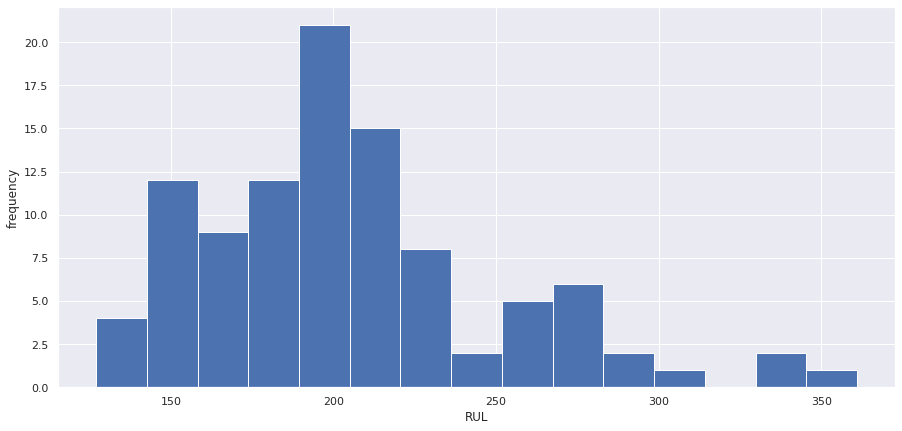

In [10]:
df_max_rul = train[['unit_nr', 'RUL']].groupby('unit_nr').max().reset_index()
df_max_rul['RUL'].hist(bins = 15, figsize=(15,7))
plt.xlabel('RUL')
plt.ylabel('frequency')
plt.show()

The histogram reconfirms most engines break down around 200 cycles. Furthermore, the distribution is right skewed, with few engines lasting over 300 cycles.

엔진 수가 많아서 모든 엔진의 모든 센서를 플로팅하기는 힘들고, unir_nr이 10의 배수만 plotting

In [11]:
def plot_sensor(sensor_name):
    plt.figure(figsize = (13,5))
    for i in train['unit_nr'].unique():
        if (i % 10 == 0):
            plt.plot('RUL', sensor_name, data = train[train['unit_nr'] == i])
    plt.xlim(250, 0) # reverse the x-axis so RUL counts down to zero
    plt.xticks(np.arange(0, 275, 25))
    plt.ylabel(sensor_name)
    plt.xlabel('Remaining Useful Life')
    plt.show()

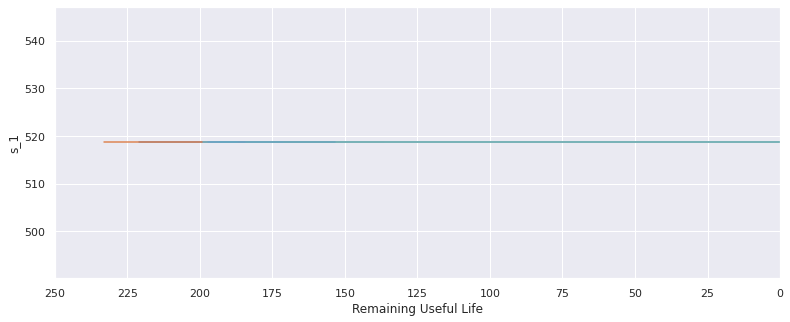

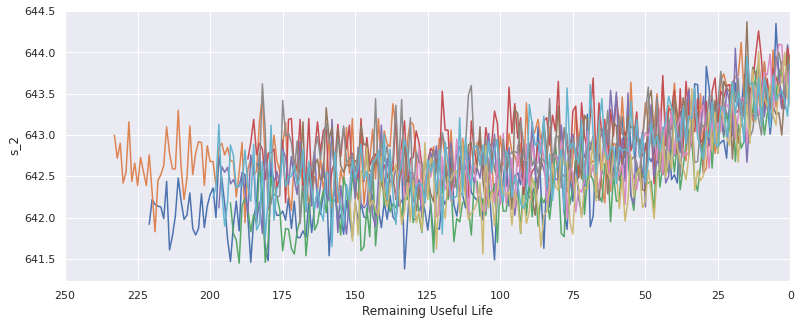

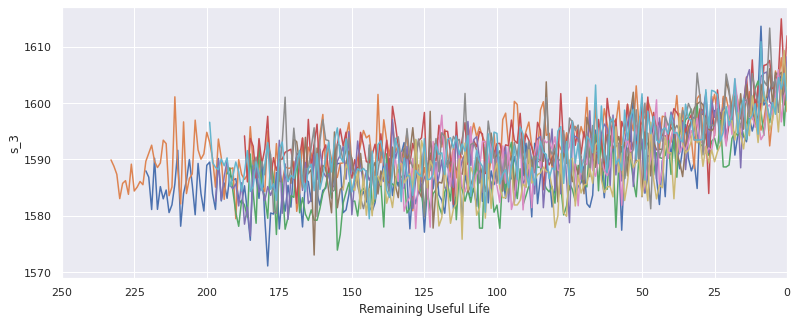

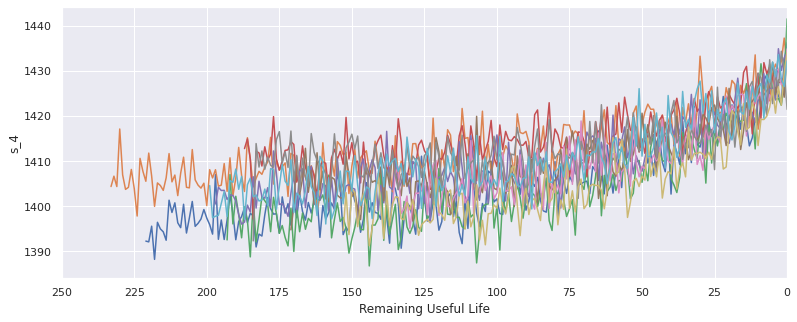

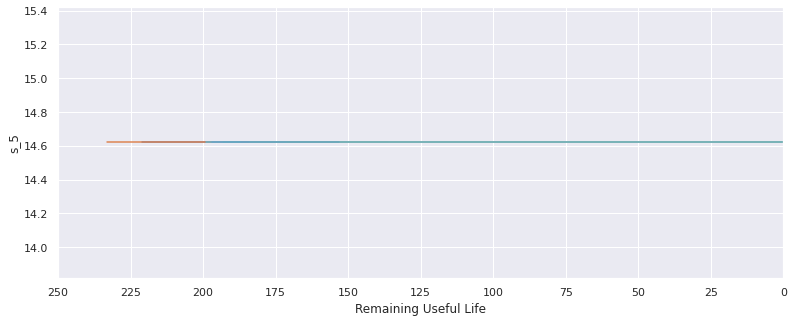

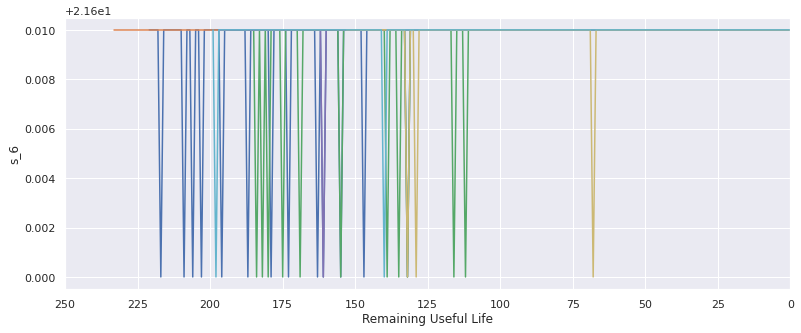

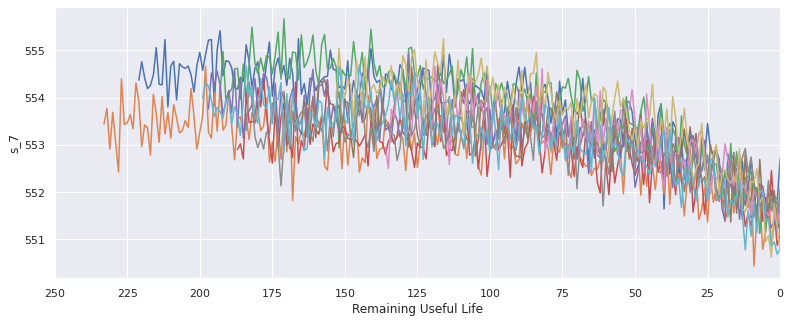

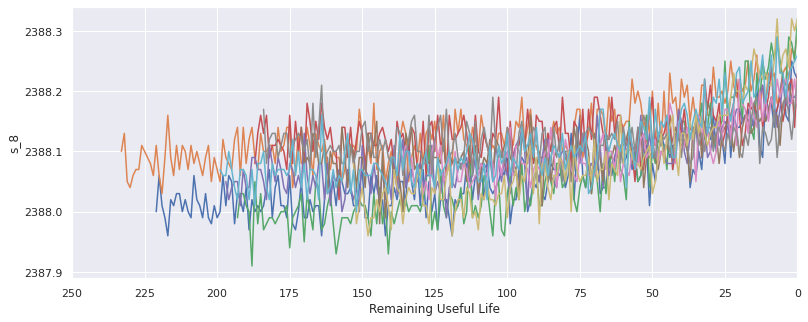

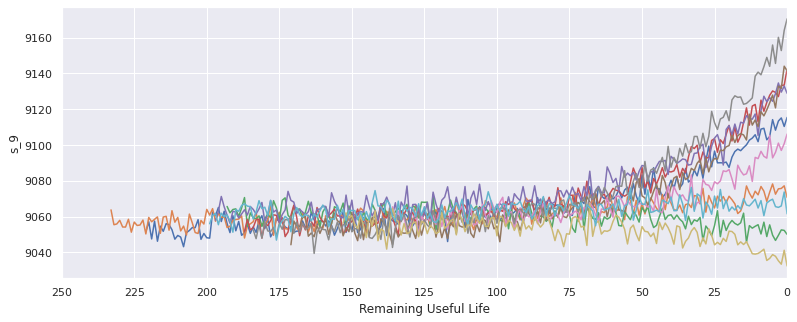

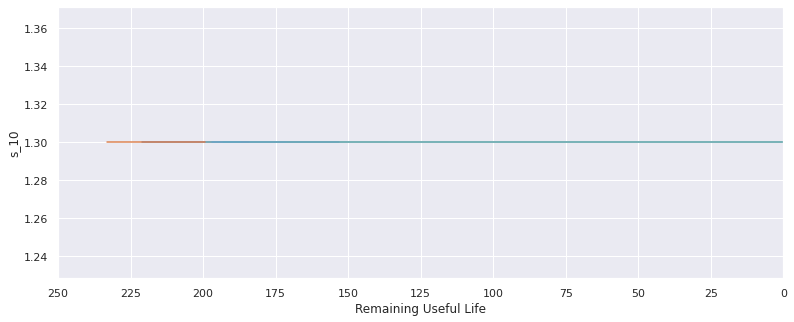

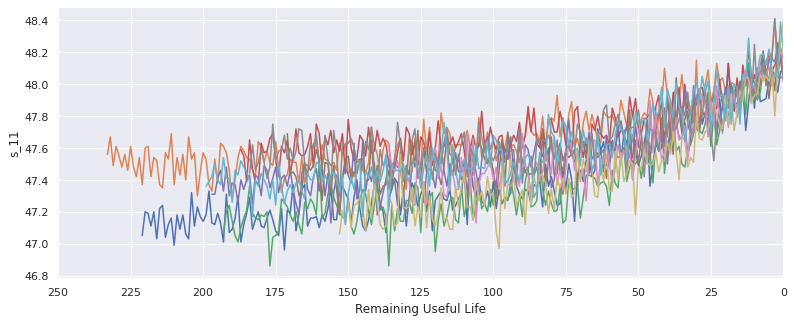

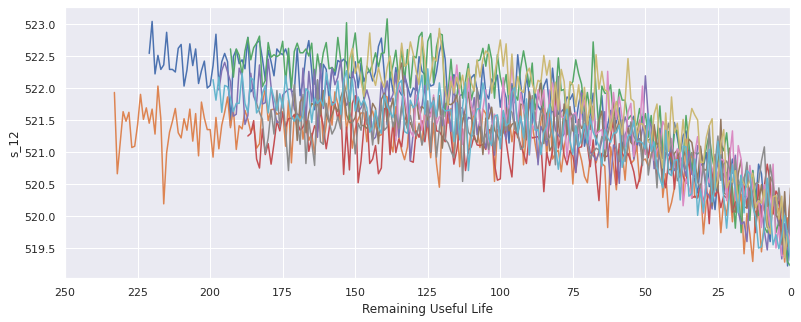

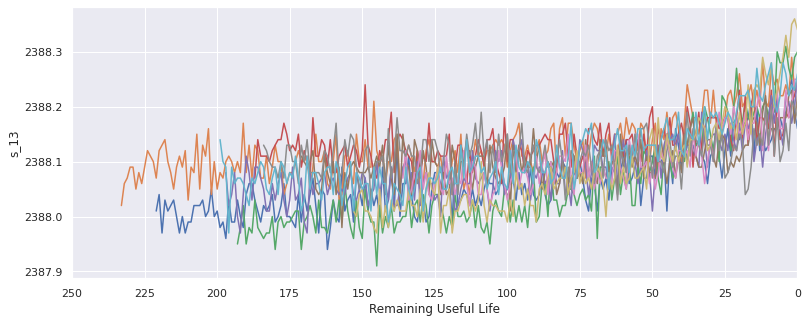

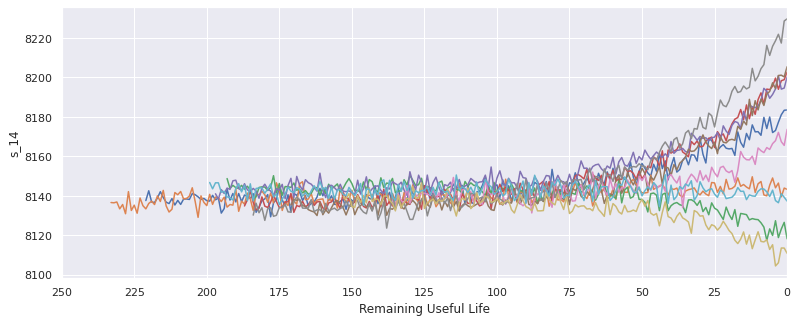

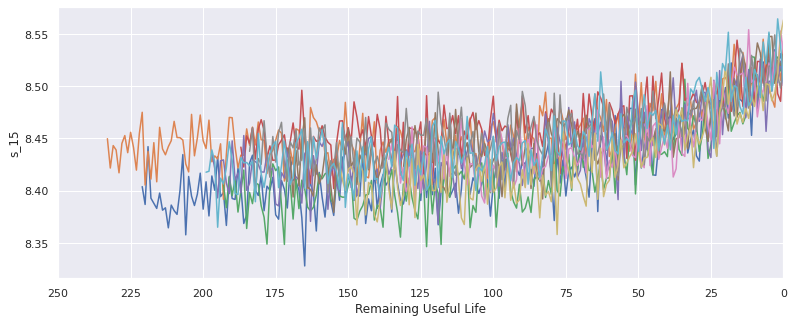

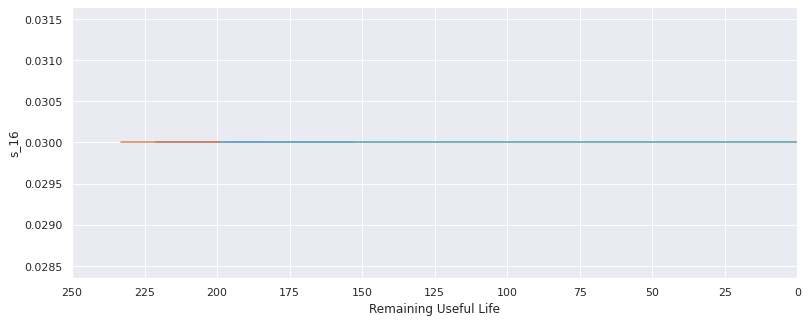

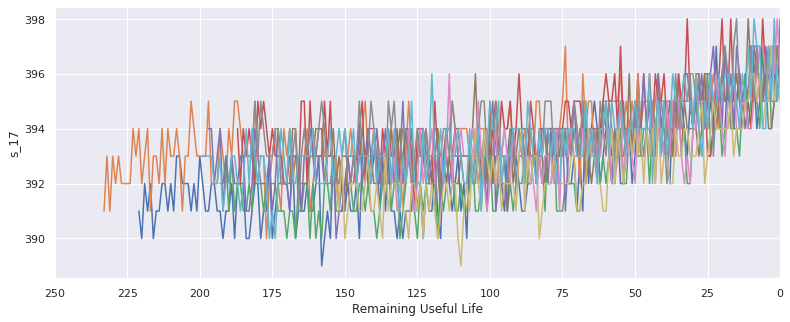

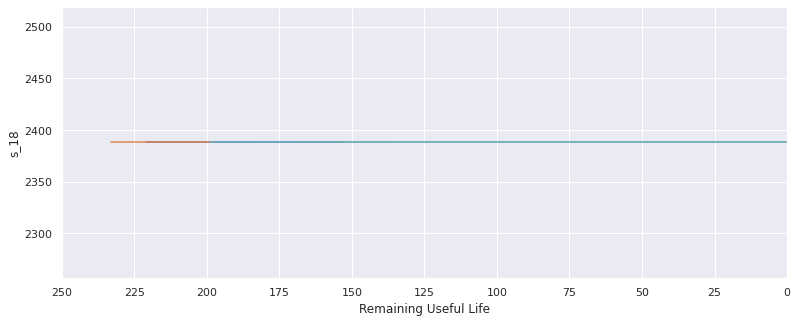

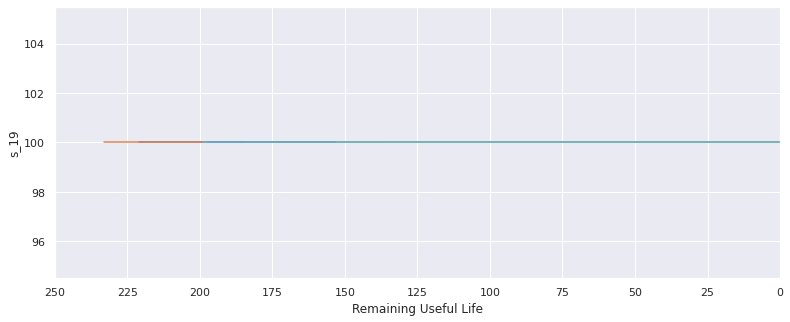

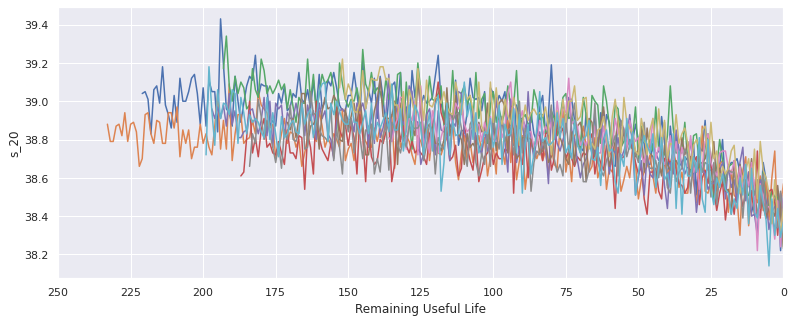

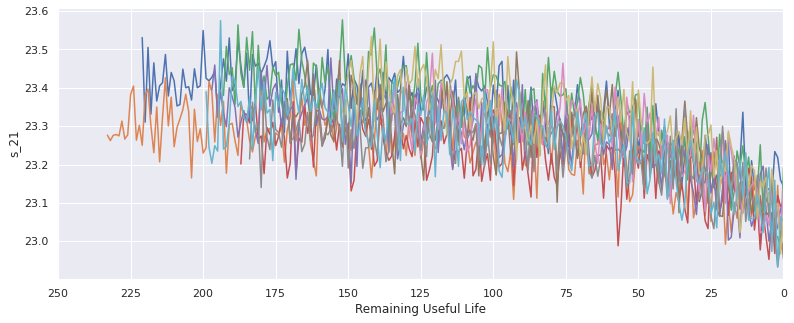

In [12]:
for sensor_name in sensor_names:
    plot_sensor(sensor_name)

#### 1.3.1. Plot Interpretation

1. No fluctuation
    * The descriptive statistics에서 확인할 수 있듯이 no fluctuation : sensor 1, 10, 18, 19 <br>
    * plot으로 봤을 때 no fluctuation: sensor 5, 16 <br>
2. Rising Trend
    * Sensor 2, 3, 4, 8, 11, 13, 15, 17
3. RUL과는 무관한 패턴을 보이는 센서
    *  Sensor 6
4. Declining Trend
    * Sensor 7, 12, 20, 21
5. Rest of the patterns
    * Sensor 9, 14

## 2. Build the baseline model

In [13]:
def evaluate(y_true, y_hat, label = 'test'):
    mse = mean_squared_error(y_true = y_true, y_pred = y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE: {}, R2: {}'.format(label, rmse, variance))

In [14]:
drop_sensors = ['s_1','s_5','s_6','s_10','s_16','s_18','s_19']
drop_labels = index_names+setting_names+drop_sensors

In [15]:
X_train = train.drop(drop_labels, axis=1)
y_train = X_train.pop('RUL')

# Since the true RUL values for the test set are only provided for the last time cycle of each enginge, 
# the test set is subsetted to represent the same
X_test = test.groupby('unit_nr').last().reset_index().drop(drop_labels, axis=1)

### 2.1. Basic Linear Regression

In [16]:
lm = LinearRegression()
lm.fit(X_train, y_train)

y_hat_train = lm.predict(X_train)
evaluate(y_train, y_hat_train, 'train')

train set RMSE: 44.66819159545432, R2: 0.5794486527796756


In [17]:
y_hat_test = lm.predict(X_test)
evaluate(y_test, y_hat_test, 'test')

test set RMSE: 31.952633027739285, R2: 0.40877368076583454


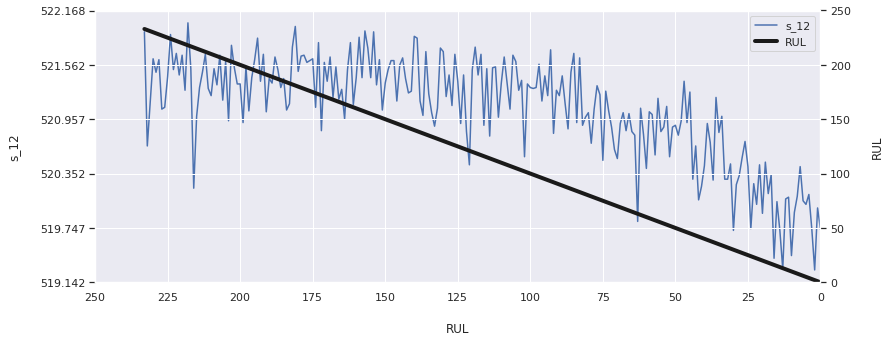

In [18]:
fig, ax1 = plt.subplots(1,1, figsize=(13,5))

signal = ax1.plot('RUL', 's_12', 'b',
                 data=train.loc[train['unit_nr']==20])
plt.xlim(250, 0)  # reverse the x-axis so RUL counts down to zero
plt.xticks(np.arange(0, 275, 25))
ax1.set_ylabel('s_12', labelpad=20)
ax1.set_xlabel('RUL', labelpad=20)

ax2 = ax1.twinx()
rul_line = ax2.plot('RUL', 'RUL', 'k', linewidth=4,
                   data=train.loc[train['unit_nr']==20])
ax2.set_ylabel('RUL', labelpad=20)


ax2.set_ylim(0, 250)  # set limits of axis you want to display neatly
ax2.set_yticks(
    np.linspace(ax2.get_ybound()[0], ax2.get_ybound()[1], 6))  # choose integer to neatly divide your axis, in our case 6
ax1.set_yticks(
    np.linspace(ax1.get_ybound()[0], ax1.get_ybound()[1], 6))  # apply same spacing to other axis

lines = signal+rul_line
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc=0)


plt.show()

* For cycle 250 - 100 (or so) the mean sensor signal is rather stable, while computed RUL is declining.
* Below 100 cycles, both the mean sensor signal and computed RUL are declining.
<br>
-> **센서는 100 사이클 이내에서 감소하는 반면에 선형 예측 모형은 쭉 감소하므로, 사이클 250 ~ 100 사이에는 
modification이 필요**

### 2.2. Clipped Linear Regression

In [19]:
## Clipped RUL
y_train_clipped = y_train.clip(upper = 125)

In [20]:
# create and fit model
lm = LinearRegression()
lm.fit(X_train, y_train_clipped)

# predict and evaluate
y_hat_train = lm.predict(X_train)
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = lm.predict(X_test)
evaluate(y_test, y_hat_test)

train set RMSE: 21.491018701514985, R2: 0.7340432868050553
test set RMSE: 21.900213406893165, R2: 0.7222608196545569


Clipping 하니까 R-squared 값이 <br>
train 0.57944 -> 0.73404 <br>
test 0.40877 -> 0.72226 <br>
으로 상승

### 2.3. Support Vector Regression

In [21]:
from sklearn.svm import SVR
svr = SVR(kernel='linear')
svr.fit(X_train, y_train_clipped)

y_hat_train = svr.predict(X_train)
evaluate(y_train_clipped, y_hat_train, 'train')


y_hat_test = svr.predict(X_test)
evaluate(y_test, y_hat_test)

train set RMSE: 30.935591377378746, R2: 0.448921080628116
test set RMSE: 33.009842780487034, R2: 0.369002893795529


Let's try and improve this model by scaling our features

#### 2.3.1. Scaling

In [34]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# SVM regression + clipped RUL + scaled
svr = SVR(kernel = 'linear')
svr.fit(X_train_scaled, y_train_clipped)

# Predict and Evaluate
y_hat_train = svr.predict(X_train_scaled)
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = svr.predict(X_test_scaled)
evaluate(y_test, y_hat_test)

train set RMSE: 21.578263975067884, R2: 0.7318795396979634
test set RMSE: 21.580480163289625, R2: 0.7303113540952153


## 3. Feature Engineering

In [36]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2)
X_train_transformed = poly.fit_transform(X_train_scaled)
X_test_transformed = poly.fit_transform(X_test_scaled)

print(X_train_scaled.shape)
print(X_train_transformed.shape)

(20631, 14)
(20631, 120)


After engineering the new features, we fit a new model

In [37]:
svr_f = SVR(kernel = 'linear')
svr_f.fit(X_train_transformed, y_train_clipped)

y_hat_train = svr_f.predict(X_train_transformed)
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = svr_f.predict(X_test_transformed)
evaluate(y_test, y_hat_test)

train set RMSE: 19.71678973113081, R2: 0.776143678570415
test set RMSE: 20.585402508371395, R2: 0.754608688211511


## 4. Feature Selection

In [39]:
from sklearn.feature_selection import SelectFromModel
select_features = SelectFromModel(svr_f, threshold = 'mean', prefit = True)
select_features.get_support()
feature_names = poly.get_feature_names()

print('Original features:\n', X_train.columns)
print('Best features:\n', np.array(feature_names)[select_features.get_support()])
np.array(feature_names)[select_features.get_support()].shape

Original features:
 Index(['s_2', 's_3', 's_4', 's_7', 's_8', 's_9', 's_11', 's_12', 's_13',
       's_14', 's_15', 's_17', 's_20', 's_21'],
      dtype='object')
Best features:
 ['x0' 'x1' 'x2' 'x3' 'x5' 'x6' 'x7' 'x9' 'x10' 'x11' 'x12' 'x13' 'x2 x5'
 'x2 x8' 'x2 x9' 'x3 x5' 'x3 x8' 'x3 x9' 'x4^2' 'x4 x6' 'x4 x7' 'x4 x8'
 'x5^2' 'x5 x6' 'x5 x7' 'x5 x9' 'x5 x12' 'x5 x13' 'x6^2' 'x6 x8' 'x6 x9'
 'x7 x8' 'x7 x9' 'x8^2' 'x9^2' 'x9 x12' 'x9 x13']


(37,)

* A new SVR model is fitted and evaluated with the select features

In [40]:
# SVM regression + clipped RUL + engineered features + selection
svr = SVR(kernel='linear')
svr.fit(X_train_transformed[:, select_features.get_support()], y_train_clipped)

# predict and evaluate
y_hat_train = svr.predict(X_train_transformed[:, select_features.get_support()])
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = svr.predict(X_test_transformed[:, select_features.get_support()])
evaluate(y_test, y_hat_test)

train set RMSE: 19.746789101481117, R2: 0.7754619593165272
test set RMSE: 20.55613819605447, R2: 0.7553058913450734


Optimizing the model

In [41]:
epsilon = [0.4, 0.3, 0.2, 0.1, 0.05]

for e in epsilon:
    svr = SVR(kernel='linear', epsilon=e)
    svr.fit(X_train_transformed[:, select_features.get_support()], y_train_clipped)
    
    # predict and evaluate
    y_hat = svr.predict(X_train_transformed[:, select_features.get_support()])
    mse = mean_squared_error(y_train_clipped, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_train_clipped, y_hat)
    print("epsilon:", e, "RMSE:", rmse, "R2:", variance)

epsilon: 0.4 RMSE: 19.74772556660335 R2: 0.7754406619776464
epsilon: 0.3 RMSE: 19.74758076106984 R2: 0.775443955249615
epsilon: 0.2 RMSE: 19.74660007817171 R2: 0.7754662580123992
epsilon: 0.1 RMSE: 19.746789101481117 R2: 0.7754619593165272
epsilon: 0.05 RMSE: 19.746532456984017 R2: 0.7754677958176166


## 5. Time Series Approach

1. Predicting sensor values and setting 'alarm' thresholds. The component is deteriorated to a state in which breakdown is imminent when a sensor is predicted to cross this threshold. There are a few caveats using this approach for the current dataset.
    1. Every sensor has to be modelled individaully, therefore we cannot make use of interactions between sensors
    2. It requires a lot of domain knowledge for setting the appropriate thresholds
    3. It doesn't directly inform us about our target feature, the Remaining Useful Life.
2. Vector Autoregression (VAR) type models. These types of models can handle multivariate timeseries, however the model initially creates lags of both our X and Y variables. Normally in timeseries the past values of Y play a large role in determining future values of Y. But since we assume our values for Y to be constant or linearly declining in the training set, incorporat